In [1]:
# imports and stuff
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable

In [7]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ristoknnapas","key":"f558b18ff3c4dc017320272efad1b207"}'}

In [9]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [10]:
! cp kaggle.json ~/.kaggle/

In [11]:
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
! kaggle datasets list

ref                                                           title                                                size  lastUpdated          downloadCount  
------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
utkarshxy/who-worldhealth-statistics-2020-complete            World Health Statistics 2020|Complete|Geo-Analysis    1MB  2021-01-14 18:29:44           4695  
gpreda/pfizer-vaccine-tweets                                  Pfizer Vaccine Tweets                               665KB  2021-01-20 08:29:59           2888  
arashnic/covid19-case-surveillance-public-use-dataset         Covid-19 Case Surveillance Public Use Dataset        46MB  2020-12-21 02:24:21           2448  
ashkhagan/women-representation-in-city-property-sanfrancisco  Women Representation in City Property SanFrancisco    3KB  2020-12-13 05:18:14            593  
google/android-smartphones-high-accuracy-datasets   

In [13]:
!kaggle competitions download -c dstl-satellite-imagery-feature-detection

  0% 0.00/2.17k [00:00<?, ?B/s]
100% 2.17k/2.17k [00:00<00:00, 1.90MB/s]
100% 7.28G/7.30G [01:51<00:00, 101MB/s] 
100% 7.30G/7.30G [01:51<00:00, 70.4MB/s]
100% 12.9G/12.9G [03:47<00:00, 56.9MB/s]
100% 12.9G/12.9G [03:48<00:00, 60.6MB/s]
  0% 0.00/14.9k [00:00<?, ?B/s]
100% 14.9k/14.9k [00:00<00:00, 14.4MB/s]
 81% 9.00M/11.1M [00:00<00:00, 27.9MB/s]
100% 11.1M/11.1M [00:00<00:00, 31.3MB/s]
  7% 1.00M/14.2M [00:01<00:22, 607kB/s]
100% 14.2M/14.2M [00:01<00:00, 8.19MB/s]


In [23]:
! unzip sample_submission.csv.zip 


Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [51]:
# Code Reference: https://www.kaggle.com/amanbh/visualize-polygons-and-image-data
# Data reference: https://www.kaggle.com/c/dstl-satellite-imagery-feature-detection/data
## Disclaimer: edited by R.K.

import pandas as pd
import numpy as np

from shapely.wkt import loads as wkt_loads
from matplotlib.patches import Polygon, Patch

# decartes package makes plotting with holes much easier
from descartes.patch import PolygonPatch

import mat
plotlib.pyplot as plt
import tifffile as tiff

import pylab

In [52]:
# Give short names, sensible colors and zorders to object types
CLASSES = {1 : 'Road', 2 : 'Forrest road', 3 : 'Trees (leaves)', 4 : 'Potato field', 5 : 'Swamp', 6 : 'Trees (spiky - like Lee) 1', 7 : 'Trees (spiky - like Lee) 2',}
COLORS = {1 : '#b9c0b8', 2 : '#ededce', 3 : '#1b7837', 4 : '##c7d85c', 5 : '#a49d80', 6 : '#526041', 7 : '#4c6547',}
ZORDER = {1 : 5, 2 : 5, 3 : 4, 4 : 1, 5 : 3, 6 : 2, 7 : 7,}


In [87]:
# read the training data from train_wkt_v4.csv
df = pd.read_csv('train_wkt_v4.csv/train_wkt_v4.csv')
print(df.head())

# grid size will also be needed later..
gs = pd.read_csv('grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
print(gs.head())

# imageIds in a DataFrame
allImageIds = gs.ImageId.unique()
trainImageIds = df.ImageId.unique()


def get_image_names(imageId):
    '''
    Get the names of the tiff files
    '''
    d = {'3': '{}/{}.tif'.format("three_band", imageId),
         'A': '{}/{}_A.tif'.format("sixteen_band",imageId),
         'M': '{}/{}_M.tif'.format("sixteen_band",imageId),
         'P': '{}/{}_P.tif'.format("sixteen_band",imageId),
         }
    return d


def get_images(imageId, img_key = None):
    '''
    Load images correspoding to imageId

    Parameters
    ----------
    imageId : str
        imageId as used in grid_size.csv
    img_key : {None, '3', 'A', 'M', 'P'}, optional
        Specify this to load single image
        None loads all images and returns in a dict
        '3' loads image from three_band/
        'A' loads '_A' image from sixteen_band/
        'M' loads '_M' image from sixteen_band/
        'P' loads '_P' image from sixteen_band/

    Returns
    -------
    images : dict
        A dict of image data from TIFF files as numpy array
    '''
    img_names = get_image_names(imageId)
    images = dict()
    if img_key is None:
        for k in img_names.keys():
            images[k] = tiff.imread(img_names[k])
    else:
        images[img_key] = tiff.imread(img_names[img_key])
    return images

    ImageId  ClassType                                    MultipolygonWKT
0  6040_2_2          1                                 MULTIPOLYGON EMPTY
1  6040_2_2          2                                 MULTIPOLYGON EMPTY
2  6040_2_2          3                                 MULTIPOLYGON EMPTY
3  6040_2_2          4  MULTIPOLYGON (((0.003025 -0.007879000000000001...
4  6040_2_2          5  MULTIPOLYGON (((0.005311 -0.009044999999999999...
    ImageId      Xmax     Ymin
0  6120_2_4  0.009180 -0.00904
1  6120_2_3  0.009169 -0.00904
2  6120_2_2  0.009188 -0.00904
3  6120_2_1  0.009188 -0.00904
4  6120_2_0  0.009188 -0.00904


In [88]:
def get_size(imageId):
    """
    Get the grid size of the image

    Parameters
    ----------
    imageId : str
        imageId as used in grid_size.csv
    """
    xmax, ymin = gs[gs.ImageId == imageId].iloc[0,1:].astype(float)
    W, H = get_images(imageId, '3')['3'].shape[1:]
    return (xmax, ymin, W, H)


def is_training_image(imageId):
    '''
    Returns
    -------
    is_training_image : bool
        True if imageId belongs to training data
    '''
    return any(trainImageIds == imageId)


def plot_polygons(fig, ax, polygonsList):
    '''
    Plot descrates.PolygonPatch from list of polygons objs for each CLASS
    '''
    legend_patches = []
    for cType in polygonsList:
        print('{} : {} \tcount = {}'.format(cType, CLASSES[cType], len(polygonsList[cType])))
        legend_patches.append(Patch(color=COLORS[cType],
                                    label='{} ({})'.format(CLASSES[cType], len(polygonsList[cType]))))
        for polygon in polygonsList[cType]:
            mpl_poly = PolygonPatch(polygon,
                                    color=COLORS[cType],
                                    lw=0,
                                    alpha=0.7,
                                    zorder=ZORDER[cType])
            ax.add_patch(mpl_poly)
    # ax.relim()
    ax.autoscale_view()
    ax.set_title('Objects')
    ax.set_xticks([])
    ax.set_yticks([])
    return legend_patches

In [85]:
def plot_image(fig, ax, imageId, img_key, selected_channels=None):
    '''
    Plot get_images(imageId)[image_key] on axis/fig
    Optional: select which channels of the image are used (used for sixteen_band/ images)
    Parameters
    ----------
    img_key : str, {'3', 'P', 'N', 'A'}
        See get_images for description.
    '''
    images = get_images(imageId, img_key)
    img = images[img_key]
    title_suffix = ''
    if selected_channels is not None:
        img = img[selected_channels]
        title_suffix = ' (' + ','.join([ repr(i) for i in selected_channels ]) + ')'
    if len(img.shape) == 2:
        new_img = np.zeros((3, img.shape[0], img.shape[1]))
        new_img[0] = img
        new_img[1] = img
        new_img[2] = img
        img = new_img
    
    tiff.imshow(img, figure=fig, subplot=ax)
    ax.set_title(imageId + ' - ' + img_key + title_suffix)
    ax.set_xlabel(img.shape[-2])
    ax.set_ylabel(img.shape[-1])
    ax.set_xticks([])
    ax.set_yticks([])

In [89]:
def visualize_image(imageId, plot_all=True):
    '''         
    Plot all images and object-polygons
    
    Parameters
    ----------
    imageId : str
        imageId as used in grid_size.csv
    plot_all : bool, True by default
        If True, plots all images (from three_band/ and sixteen_band/) as subplots.
        Otherwise, only plots Polygons.
    '''         
    df_image = df[df.ImageId == imageId]
    xmax, ymin, W, H = get_size(imageId)
    
    if plot_all:
        fig, axArr = plt.subplots(figsize=(10, 10), nrows=3, ncols=3)
        ax = axArr[0][0]
    else:
        fig, axArr = plt.subplots(figsize=(10, 10))
        ax = axArr
    if is_training_image(imageId):
        print('ImageId : {}'.format(imageId))
        polygonsList = {}
        for cType in CLASSES.keys():
            polygonsList[cType] = wkt_loads(df_image[df_image.ClassType == cType].MultipolygonWKT.values[0])
        legend_patches = plot_polygons(fig, ax, polygonsList)
        ax.set_xlim(0, xmax)
        ax.set_ylim(ymin, 0)
        ax.set_xlabel(xmax)
        ax.set_ylabel(ymin)

    if is_training_image(imageId):
        ax.legend(handles=legend_patches,
                   # loc='upper center',
                   bbox_to_anchor=(0.9, 1),
                   bbox_transform=plt.gcf().transFigure,
                   ncol=5,
                   fontsize='x-small',
                   title='Objects-' + imageId,
                   # mode="expand",
                   framealpha=0.3)
    return (fig, axArr, ax)

# Loop over few training images and save to files
for imageId in trainImageIds:
    fig, axArr, ax = visualize_image(imageId, plot_all=True)
    plt.savefig('Objects--' + imageId + '.png')
    plt.clf()

ImageId : 6040_2_2
1 : Bldg 	count = 0
2 : Struct 	count = 0
3 : Road 	count = 0
4 : Track 	count = 2
5 : Trees 	count = 3879
6 : Crops 	count = 0
7 : Fast H20 	count = 0
8 : Slow H20 	count = 0
9 : Truck 	count = 0
10 : Car 	count = 0
ImageId : 6120_2_2
1 : Bldg 	count = 1962
2 : Struct 	count = 3201
3 : Road 	count = 1
4 : Track 	count = 33
5 : Trees 	count = 1452
6 : Crops 	count = 20
7 : Fast H20 	count = 0
8 : Slow H20 	count = 6
9 : Truck 	count = 9
10 : Car 	count = 548
ImageId : 6120_2_0
1 : Bldg 	count = 573
2 : Struct 	count = 1193
3 : Road 	count = 1
4 : Track 	count = 4
5 : Trees 	count = 1542
6 : Crops 	count = 67
7 : Fast H20 	count = 0
8 : Slow H20 	count = 0
9 : Truck 	count = 6
10 : Car 	count = 11
ImageId : 6090_2_0
1 : Bldg 	count = 0
2 : Struct 	count = 11
3 : Road 	count = 0
4 : Track 	count = 3
5 : Trees 	count = 2308
6 : Crops 	count = 7
7 : Fast H20 	count = 0
8 : Slow H20 	count = 19
9 : Truck 	count = 0
10 : Car 	count = 1
ImageId : 6040_1_3
1 : Bldg 	count = 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ImageId : 6060_2_3
1 : Bldg 	count = 62
2 : Struct 	count = 173
3 : Road 	count = 0
4 : Track 	count = 7
5 : Trees 	count = 1613
6 : Crops 	count = 86
7 : Fast H20 	count = 0
8 : Slow H20 	count = 0
9 : Truck 	count = 0
10 : Car 	count = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ImageId : 6070_2_3
1 : Bldg 	count = 109
2 : Struct 	count = 81
3 : Road 	count = 2
4 : Track 	count = 0
5 : Trees 	count = 41
6 : Crops 	count = 0
7 : Fast H20 	count = 24
8 : Slow H20 	count = 3
9 : Truck 	count = 0
10 : Car 	count = 13


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ImageId : 6010_1_2
1 : Bldg 	count = 0
2 : Struct 	count = 44
3 : Road 	count = 0
4 : Track 	count = 12
5 : Trees 	count = 1733
6 : Crops 	count = 0
7 : Fast H20 	count = 0
8 : Slow H20 	count = 0
9 : Truck 	count = 0
10 : Car 	count = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ImageId : 6040_4_4
1 : Bldg 	count = 0
2 : Struct 	count = 0
3 : Road 	count = 0
4 : Track 	count = 7
5 : Trees 	count = 1901
6 : Crops 	count = 0
7 : Fast H20 	count = 0
8 : Slow H20 	count = 0
9 : Truck 	count = 0
10 : Car 	count = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


ImageId : 6100_2_2
1 : Bldg 	count = 633
2 : Struct 	count = 454
3 : Road 	count = 1
4 : Track 	count = 27
5 : Trees 	count = 878
6 : Crops 	count = 11
7 : Fast H20 	count = 4
8 : Slow H20 	count = 1
9 : Truck 	count = 13
10 : Car 	count = 101


<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [ ]:
def plot_image(fig, ax, imageId, img_key, selected_channels=None):
    '''
    Plot get_images(imageId)[image_key] on axis/fig
    Optional: select which channels of the image are used (used for sixteen_band/ images)
    Parameters
    ----------
    img_key : str, {'3', 'P', 'N', 'A'}
        See get_images for description.
    '''
    images = get_images(imageId, img_key)
    img = images[img_key]
    title_suffix = ''
    if selected_channels is not None:
        img = img[selected_channels]
        title_suffix = ' (' + ','.join([ repr(i) for i in selected_channels ]) + ')'
    if len(img.shape) == 2:
        new_img = np.zeros((3, img.shape[0], img.shape[1]))
        new_img[0] = img
        new_img[1] = img
        new_img[2] = img
        img = new_img
    
    tiff.imshow(img, figure=fig, subplot=ax)
    ax.set_title(imageId + ' - ' + img_key + title_suffix)
    ax.set_xlabel(img.shape[-2])
    ax.set_ylabel(img.shape[-1])
    ax.set_xticks([])
    ax.set_yticks([])

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7fc41d2d6e10>)

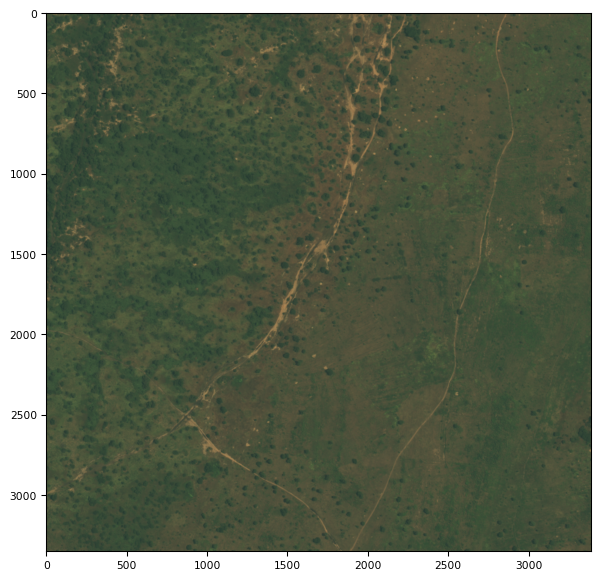

In [123]:
import tifffile as tiff
P = tiff.imread("three_band/6170_2_4.tif") 
tiff.imshow(P)

In [ ]:
visualize_image(imageId, plot_all=True)
plt.savefig('Objects--' + imageId + '.png')
plt.clf()